In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
with open("./dataset.json", "r") as f:
    data_raw = f.read()

In [3]:
data = json.loads(data_raw)

In [4]:
for i, key in enumerate(data):
    
    if i == 5:
        break
        
    print(key, data[key])
    print()

Patient 1 {'Image 764': ['Class 38', 'Class 48', 'Class 31'], 'Image 1065': ['Class 1'], 'Image 1448': ['Class 34', 'Class 3'], 'Image 2227': ['Class 29', 'Class 42'], 'Image 2377': ['Class 1', 'Class 13'], 'Image 3080': ['Class 16', 'Class 34', 'Class 11'], 'Image 3321': ['Class 42'], 'Image 4779': ['Class 10'], 'Image 5395': ['Class 36', 'Class 11', 'Class 19'], 'Image 6837': ['Class 22', 'Class 1'], 'Image 8190': ['Class 38'], 'Image 9830': ['Class 30', 'Class 40', 'Class 41']}

Patient 2 {'Image 2623': ['Class 16', 'Class 11'], 'Image 2753': ['Class 29', 'Class 17', 'Class 4'], 'Image 3945': ['Class 43', 'Class 39', 'Class 11'], 'Image 4799': ['Class 14'], 'Image 4874': ['Class 6'], 'Image 5466': ['Class 23'], 'Image 6639': ['Class 22'], 'Image 7169': ['Class 11'], 'Image 7844': ['Class 14'], 'Image 8475': ['Class 1']}

Patient 3 {'Image 149': ['Class 48'], 'Image 1765': ['Class 14'], 'Image 2424': ['Class 11', 'Class 31'], 'Image 6247': ['Class 26', 'Class 41'], 'Image 6831': ['Cl

In [5]:
# number of patients

patients = np.array(list(data.keys()))
len(patients)

total_images = 0
classes = []

for patient in data:
    
    images = data[patient]
    
    total_images += len(images)


    for image in images:
        
        cls = data[patient][image]
        
        for key in cls:
            classes.append(key)
        
print("# Patients:", len(patients))
print("# Images:", total_images)
print("# Classes:", len(set(classes)))

# Patients: 1000
# Images: 10000
# Classes: 50


# Target Distribution for Each Partition

In [6]:
dist = Counter(classes)

In [7]:
pairs = sorted(list(dist.items()), key=lambda x : int(x[0].split(" ")[-1]))

In [8]:
target_xs = [ p[0] for p in pairs ]
target_ys = [ p[1] for p in pairs ]

In [9]:
target_ys_norm = np.array(target_ys) / sum(target_ys)

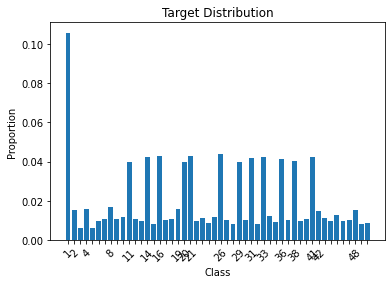

In [10]:
plt.title("Target Distribution")
plt.bar(target_xs, target_ys_norm)
plt.ylabel("Proportion")
plt.xlabel("Class")


# Identify outliers
orig_outlier_labels = target_ys_norm > 0.013

plt.xticks(ticks=range(50),
           labels=[ i if orig_outlier_labels[i-1] else "" for i in range(1, 50+1) ],
           rotation="45")

plt.show()

# Random Search Optimization

In [11]:
def kl_divergence(p, q):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

In [12]:
# 80 : 10 : 10 splits

In [13]:
def cal_dist_of_split(split):

    total_images = 0
    classes = []
    
    for patient in patients[split]:

        images = data[patient]

        total_images += len(images)

        for image in images:

            cls = data[patient][image]

            for key in cls:
                classes.append(key)
                
    sample_dist = Counter(classes)
    
    pairs = sorted(list(sample_dist.items()), key=lambda x : int(x[0].split(" ")[-1]))
    
    
    sample_xs = [ p[0] for p in pairs ]
    sample_ys = [ p[1] for p in pairs ]

    sample_ys_norm = np.array(sample_ys) / sum(sample_ys)
    
    # loss
    loss = kl_divergence(target_ys_norm, sample_ys_norm)
    
    return loss, sample_ys_norm

In [14]:
def get_random_split():
    indices = np.arange(1000)

    np.random.shuffle(indices)


    train_split = indices[:800]
    val_split = indices[800:900]
    test_split = indices[900::]


    # Calc Stats for each split and measure distance to target distribution
    train_loss, train_dist = cal_dist_of_split(train_split)
    val_loss,   val_dist   = cal_dist_of_split(val_split)
    test_loss,  test_dist  = cal_dist_of_split(test_split)
    
    total_loss = val_loss + test_loss

    return total_loss, indices, { "train": train_dist,  "val": val_dist, "test": test_dist} 

In [15]:
# N random searches
results = []
N = 10_000
for step in range(N):
    
    per = (step+1) / N * 100
    
    print(f"{per:.2f}%", end="\r")
    
    exp = get_random_split()
    
    results.append(exp)

In [16]:
# Rank results
sorted_results = sorted(results, key=lambda x: x[0])

In [17]:
# Compare best and worse
best = sorted_results[0]
worst = sorted_results[-1]

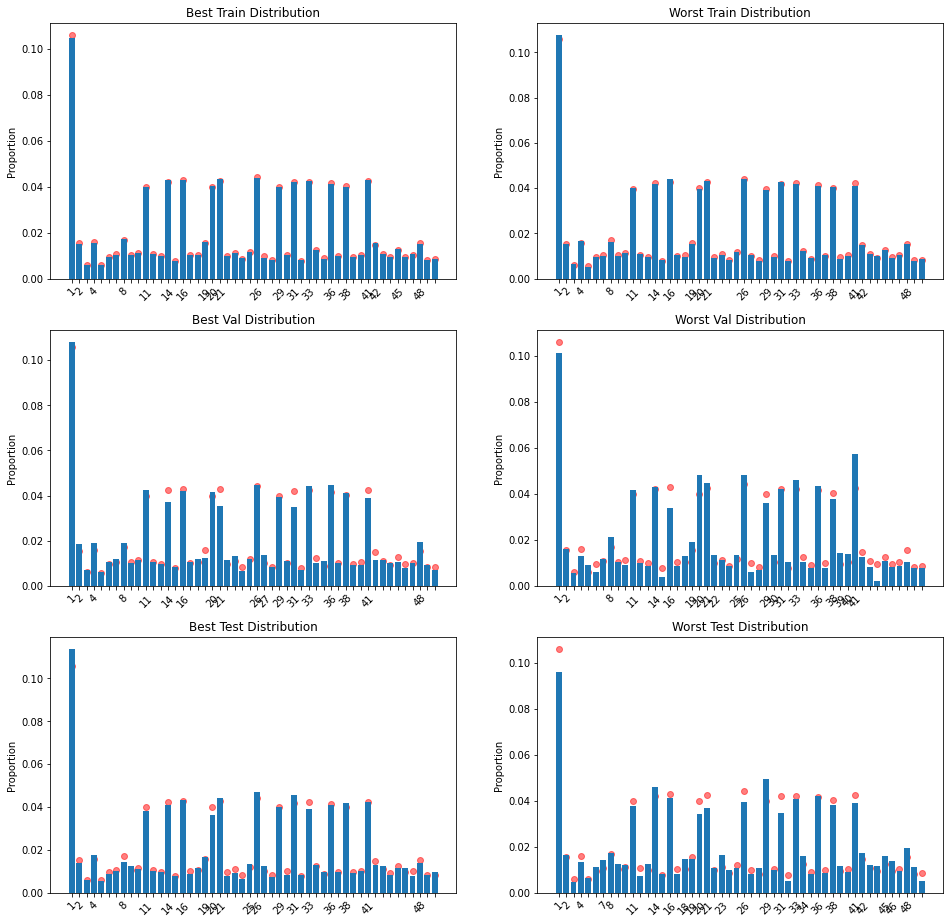

In [18]:
# Identify outliers

fig, ax = plt.subplots(3, 2, figsize=(16, 16))

# -------------- BEST ---------------------- #
for i, name in enumerate(["train", "val", "test"]):

    split = best[-1][name]
    
    ax[i, 0].set_title(f"Best { name.capitalize() } Distribution")
    ax[i, 0].bar(target_xs, split)
    ax[i, 0].scatter(target_xs, target_ys_norm, color="red", alpha=0.5)
    ax[i, 0].set_ylabel("Proportion")
    ax[i, 0].set_xticks(ticks=range(50))

    outlier_labels = split > 0.013
    ax[i, 0].set_xticklabels(
               labels=[ i if outlier_labels[i-1] else "" for i in range(1, 50+1) ],
               rotation="45")

# ---------- WORST ------------------------- #
for i, name in enumerate(["train", "val", "test"]):

    split = worst[-1][name]
    
    ax[i, 1].set_title(f"Worst { name.capitalize() } Distribution")
    ax[i, 1].bar(target_xs, split)
    ax[i, 1].scatter(target_xs, target_ys_norm, color="red", alpha=0.5)
    ax[i, 1].set_ylabel("Proportion")
    ax[i, 1].set_xticks(ticks=range(50))

    outlier_labels = split > 0.013
    ax[i, 1].set_xticklabels(
               labels=[ i if outlier_labels[i-1] else "" for i in range(1, 50+1) ],
               rotation="45")


plt.show()

In [19]:
# Target outliers
np.where(orig_outlier_labels == True)[0] + 1

array([ 1,  2,  4,  8, 11, 14, 16, 19, 20, 21, 26, 29, 31, 33, 36, 38, 41,
       42, 48])

# Save Splits

In [20]:
indices = best[1]

In [21]:
train_patients = patients[indices[0:800]]
val_patients = patients[indices[800:900]]
test_patients = patients[indices[900:]]

In [22]:
result = {
    "Training Set": [],
    "Validation Set": [],
    "Test Set": []
}

In [23]:
# Train
for patient in train_patients:
    for image in data[patient]:
        result["Training Set"].append(image)
        
# Validation
for patient in val_patients:
    for image in data[patient]:
        result["Validation Set"].append(image)
        
# Test
for patient in test_patients:
    for image in data[patient]:
        result["Test Set"].append(image)

In [24]:
with open("result.json", "w") as f:
    
    f.write(json.dumps(result))
    

In [25]:
result

{'Training Set': ['Image 808',
  'Image 1763',
  'Image 2228',
  'Image 2630',
  'Image 2864',
  'Image 3415',
  'Image 4024',
  'Image 4508',
  'Image 5538',
  'Image 6131',
  'Image 6385',
  'Image 6947',
  'Image 8183',
  'Image 9915',
  'Image 9974',
  'Image 9996',
  'Image 325',
  'Image 483',
  'Image 1198',
  'Image 1854',
  'Image 2510',
  'Image 3740',
  'Image 4840',
  'Image 5331',
  'Image 6231',
  'Image 6423',
  'Image 6607',
  'Image 7010',
  'Image 7184',
  'Image 9661',
  'Image 9968',
  'Image 184',
  'Image 582',
  'Image 1631',
  'Image 1657',
  'Image 2371',
  'Image 3084',
  'Image 5787',
  'Image 6214',
  'Image 6457',
  'Image 6858',
  'Image 8092',
  'Image 8629',
  'Image 8697',
  'Image 1001',
  'Image 1346',
  'Image 1598',
  'Image 4389',
  'Image 5539',
  'Image 6089',
  'Image 6708',
  'Image 7521',
  'Image 7721',
  'Image 7960',
  'Image 8485',
  'Image 2861',
  'Image 4484',
  'Image 4783',
  'Image 5992',
  'Image 6315',
  'Image 7806',
  'Image 8277

In [26]:
for key in result:
    print(key, "#", len(result[key]), "images")

Training Set # 7978 images
Validation Set # 993 images
Test Set # 1029 images
